In [21]:
class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        #self.original_x_shape = None
        
    def forward(self,x):
#         self.original_x_shape = x.shape
#         x = x.reshape(x.shape[0],-1)
        self.x = x
        
        out = np.dot(self.x,self.W) + self.b
        return out
    
    def backward(self,dout):
        self.dW = np.dot(self.x.T , dout)
        dx = np.dot(dout, self.W.T)
        self.db = np.sum(dout, axis=0)
        
#         dx = dx.reshape(*self.original_x_shape)
        return dx

In [2]:
class ReLU:
    def __init__(self):
        self.mask = None
    
    def forward(self,x):
        self.mask = (x<=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        return dout

In [3]:
def softmax(x):
    c = max(x)
    exp_a = np.exp(x - c)
    sum_exp_a  = np.sum(exp_a)
    return exp_a / sum_exp_a

In [4]:
def cross_entropy_error(y,t):
    if y.dim == 1:
        y = y.reshape(1,y.size)
        t = t.reshape(1,t.size)
    
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-4))/batch_size

In [5]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
        
    def forward(self,x,t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t) 
        return self.loss
    
    def backward(self,dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

In [54]:
import numpy as np
# from common.layers import * 
# from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self,input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params={}
        self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)
        
        #계층생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    #x : 입력데이터 t:정답레이블
    def loss(self,x,t):
        y = self.predict(x)
        return self.lastLayer.forward(y,t)
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        if t.ndim != 1: 
            t = np.argmax(t,axis=1)
            
        accuracy = np.sum(y==t) / float(x.shape[0])
        return accuracy
    
    def gradient(self,x,t):
        #순전파
        self.loss(x,t)
        
        #역전파
        dout=1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads={}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

In [55]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50,output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_backprop = network.gradient(x_batch,t_batch)

for key in grad_backprop.keys():
    print(key + ':' + str(grad_backprop[key]))
    
print(grad_backprop['W1'].shape)

W1:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
b1:[ 7.39443866e-04 -8.55785485e-04  1.00478197e-03  8.61584888e-03
  1.43255523e-03 -2.82089456e-03  0.00000000e+00  3.73086992e-03
  1.68223064e-03  8.84284329e-03 -7.50291449e-05 -3.52901784e-03
  5.55046347e-03  2.38554071e-04 -1.93759178e-03  6.21252989e-03
  1.75397541e-03  0.00000000e+00  1.26372680e-03 -1.02004453e-03
 -2.43655613e-03 -2.74542205e-03 -4.35673023e-03  0.00000000e+00
  4.71990955e-04  1.38596710e-03  4.48586519e-03 -5.15536053e-03
  2.23690670e-03 -4.43310866e-03  0.00000000e+00  0.00000000e+00
  3.05329842e-06  1.09287050e-03  1.32380264e-03  3.48851839e-03
  6.82697513e-04  7.03851360e-03  0.00000000e+00  4.01775950e-03
  5.85190568e-03  0.00000000e+00  1.51777847e-03 -4.57661722e-03
  0.00000000e+00  8.38833950e-03  1.82652263e-03 -6.73294629e-03
 -2.48263063e-03  0.00000000e+00]
W2:[[-1.33993987e-02  1.

## 학습구현하기

In [41]:
network = TwoLayerNet(input_size=784, hidden_size=50,output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size=100
learning_rate=0.1

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]

iter_per_epoch = max(train_size / batch_size,1) #600

for i in range(iters_num): #10000반복
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = network.gradient(x_batch,t_batch)
    
    for key in ('W1','b1','W2','b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0: # i % 600
        train_acc = network.accuracy(x_train,t_train)
        test_acc = network.accuracy(x_test,t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.10261666666666666 0.1015
0.9007333333333334 0.9049
0.9229166666666667 0.9238
0.9371166666666667 0.9368
0.94515 0.9419
0.9510833333333333 0.9475
0.9562833333333334 0.9526
0.9614833333333334 0.958
0.96325 0.9598
0.9666333333333333 0.9634
0.9702833333333334 0.9661
0.9712333333333333 0.9671
0.9736666666666667 0.969
0.9749666666666666 0.9692
0.97685 0.9703
0.978 0.9718
0.9794166666666667 0.9709


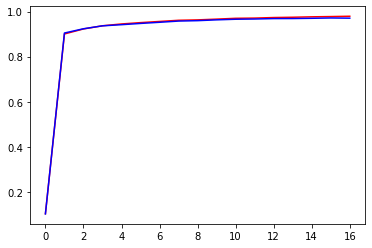

In [44]:
import matplotlib.pyplot as plt

plt.plot(np.arange(17),train_acc_list,c='r')
plt.plot(np.arange(17),test_acc_list,c='b')
plt.show()

In [52]:
print(10000 / 600)

16.666666666666668


In [49]:
(x_train,t_train),(x_test,t_test) = load_mnist(normalize=True,one_hot_label=True)

print(x_train.shape)

(60000, 784)
